# Using Deep Learning to Detect Pneumonia from X-Rays

<img src = '../images/x-rays.png'/>

## Objectives
***
The objective of this analysis was to build a machine learning model that can detect whether or not a patient has pneumonia by classfiying X-ray images.

## Background Information 
***
According to the [Mayo Clinic Website](https://www.mayoclinic.org/diseases-conditions/pneumonia/symptoms-causes/syc-20354204#:~:text=Pneumonia%20is%20an%20infection%20that,and%20fungi%2C%20can%20cause%20pneumonia.), "Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia. Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems." 

<img src = '../images/pneumonia.png' />

## Data Understanding
***
The x-ray images used for this analysis were obtained from Guangzhou Women and Children’s Medical Center, Guangzhou, China. These x-rays were obtained from pediatric patients ranging from the ages one to five as part of their normal routine care. All images that were of low quality or unreadable were removed and were reviews by three expert physicians for the purpose of AI analysis.

The dataset was organized into 3 folders (test, training, and validation) and within each folders there were subfolders for each category (Pneumonia/Normal). In total there are 5,863 X-Ray images. The dataset was downloaded from the [Kaggle website](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

## Preprocessing
***
For the preprocessing stage of this image classification task, I created data generators of training, testing, validation data using the Keras ImageDataGenerator function. I rescaled the images 1/255. I wanted the pixels for each image to be 128 X 128 so I put that in target_size. I made the class_mode parameter 'binary' since this is a binary problem. I set the batch_size according to the amount of images for each test, training, and validation set.

## Modeling
***
For this analysis, I created a binary CNN (Convolution Neural Network) to classify the X-Ray images. I used classification reports for the models to give me accuracy, loss, recall, precision, and F1 score metrics. I also built a pretrained VGG19 transfer learning to classify the X-Ray Images. You can learn more about VGG19 classification and detection [here](https://keras.io/api/applications/vgg/).

# Data Preprocessing and Modeling

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import itertools

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, Adadelta, Adagrad, SGD, RMSprop

import os

In [2]:
from tensorflow.random import set_seed
set_seed(321)

import numpy as np
np.random.seed(123)

***
## Preprocessing

### Create directory paths for image data

In [3]:
data_train_dir = '../chest_xray/train/'
data_test_dir = '../chest_xray/test/'
data_val_dir = '../chest_xray/val/'

In [4]:
train_dir_pneumonia = '../chest_xray/train/PNEUMONIA'
train_dir_normal = '../chest_xray/train/NORMAL'
test_dir_pneumonia = '../chest_xray/test/PNEUMONIA'
test_dir_normal = '../chest_xray/test/NORMAL'
val_dir_pneumonia = '../chest_xray/val/PNEUMONIA'
val_dir_normal = '../chest_xray/val/NORMAL'

In [5]:
# Review image count
print('Train Pneumonia: ', len(os.listdir(train_dir_pneumonia)))
print('Train Normal: ', len(os.listdir(train_dir_normal)))
print('Test Pneumonia: ', len(os.listdir(test_dir_pneumonia)))
print('Test Normal: ', len(os.listdir(test_dir_normal)))
print('Val Pneumonia: ', len(os.listdir(val_dir_pneumonia)))
print('Val Normal: ', len(os.listdir(val_dir_normal)))

Train Pneumonia:  3875
Train Normal:  1341
Test Pneumonia:  390
Test Normal:  234
Val Pneumonia:  8
Val Normal:  8


### Create data generators
Creating data generators of training, testing, validation data. I want the pixels for each image to be 128 X 128 so I put that in target_size. The class_mode is binary since this is a binary problem. I set the batch_size according to the image count above.

In [6]:
train_generator = ImageDataGenerator(rescale = 1./255 ).flow_from_directory(data_train_dir,
                                                                            target_size=(128,128),
                                                                            batch_size=5216,
                                                                            class_mode='binary',
                                                                            seed=123)

Found 5216 images belonging to 2 classes.


In [7]:
test_generator = ImageDataGenerator(rescale = 1./255 ).flow_from_directory(data_test_dir,
                                                                            target_size=(128,128),
                                                                            batch_size=624,
                                                                            class_mode='binary',
                                                                            seed=123)

Found 624 images belonging to 2 classes.


In [8]:
val_generator = ImageDataGenerator(rescale = 1./255 ).flow_from_directory(data_val_dir,
                                                                            target_size=(128,128),
                                                                            batch_size=16,
                                                                            class_mode='binary',
                                                                            seed=123)

Found 16 images belonging to 2 classes.


### Review Class Indices

In [9]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [10]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [11]:
val_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

### Create datasets

In [12]:
# use train_split_test instead
from sklearn.model_selection import train_test_split

In [13]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [14]:
index = np.arange(0, test_images.shape[0])

In [17]:
n_valimages = round(test_images.shape[0]*0.2)

In [18]:
val_index = np.random.choice(index, n_valimages, replace=False)
len(val_index)

125

In [19]:
val_index[:10]

array([176, 326, 483, 402, 353, 557,  78, 444,  57, 261])

In [27]:
test_index = [i for i in index if i not in val_index]
len(test_index)

499

In [28]:
X_val_split = test_images[val_index]
y_val_split = test_labels[val_index]

X_test_split = test_images[test_index]
y_test_split = test_labels[test_index]

X_val_split.shape, X_test_split.shape

((125, 128, 128, 3), (499, 128, 128, 3))

In [39]:
val_images.shape

(16, 128, 128, 3)

In [40]:
train_images.shape

(5216, 128, 128, 3)

### Review image shapes 

In [29]:
print('Train Images Shape:', np.shape(train_images))
print('Train Labels Shape:', np.shape(train_labels))
print('Test Images Shape:' , np.shape(test_images))
print('Test Labels Shape:' , np.shape(test_labels))
print('Validation Images Shape:', np.shape(val_images))
print('Validation Labels Shape:', np.shape(val_labels))

Train Images Shape: (5216, 128, 128, 3)
Train Labels Shape: (5216,)
Test Images Shape: (624, 128, 128, 3)
Test Labels Shape: (624,)
Validation Images Shape: (16, 128, 128, 3)
Validation Labels Shape: (16,)


***
## Modeling

### Baseline model: 3 Convolution layes, 3 max pooling layers, and 1 fully connected layer

In [30]:
input_shape = (128, 128, 3)

In [31]:
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

baseline_model = models.Sequential()

baseline_model.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=input_shape))

baseline_model.add(MaxPooling2D((2, 2)))

baseline_model.add(Conv2D(32, (3, 3), activation='relu'))
baseline_model.add(MaxPooling2D(2, 2))

baseline_model.add(Conv2D(64, (3, 3), activation='relu'))
baseline_model.add(MaxPooling2D((2, 2)))

baseline_model.add(Flatten())
baseline_model.add(Dense(64, activation='relu'))
baseline_model.add(Dense(1, activation='sigmoid'))

In [32]:
baseline_model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])

In [33]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [44]:
# try bumping batch size to 64
base_history = baseline_model.fit(train_images,
                       train_labels,
                       epochs=25,
                       batch_size=50,
                       validation_data=(X_val_split, y_val_split))
                        #validation_split=0.2)

Epoch 1/25
105/105 [==============================] - 89s 852ms/step - loss: 7.8512e-06 - acc: 1.0000 - val_loss: 5.3729 - val_acc: 0.7040
Epoch 2/25
105/105 [==============================] - 78s 741ms/step - loss: 7.3553e-06 - acc: 1.0000 - val_loss: 5.4848 - val_acc: 0.6960
Epoch 3/25
105/105 [==============================] - 79s 757ms/step - loss: 6.8059e-06 - acc: 1.0000 - val_loss: 5.4279 - val_acc: 0.7040
Epoch 4/25
105/105 [==============================] - 73s 698ms/step - loss: 6.3691e-06 - acc: 1.0000 - val_loss: 5.4763 - val_acc: 0.7040
Epoch 5/25
105/105 [==============================] - 77s 731ms/step - loss: 5.8824e-06 - acc: 1.0000 - val_loss: 5.5964 - val_acc: 0.6960
Epoch 6/25
105/105 [==============================] - 78s 739ms/step - loss: 5.5329e-06 - acc: 1.0000 - val_loss: 5.6207 - val_acc: 0.6960
Epoch 7/25
105/105 [==============================] - 76s 722ms/step - loss: 5.2211e-06 - acc: 1.0000 - val_loss: 5.5726 - val_acc: 0.6960
Epoch 8/25
105/105 [=======

In [75]:
import seaborn as sns
def eval_results(results):
    '''This function will create accuracy and loss graphs,
    confusion matrix, and print out classification report'''
    history = results.history
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure()
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.legend(['acc', 'val_acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

    y_hat_test = results.model.predict(test_images)
    thresh = 0.5
    y_pred = y_hat_test.round()
    #y_pred = (y_hat_test < thresh).astype(np.int)
    y_true = test_labels.astype(np.int)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Model Confusion Matrix')
    plt.show()
    print('\n')

    print(classification_report(y_true, y_pred))
    print('\n')

    test_loss, test_acc = results.model.evaluate(test_images, test_labels)
    print(f'Test Loss: {test_loss}')
    print(f'Test Acc: {test_acc}')
    

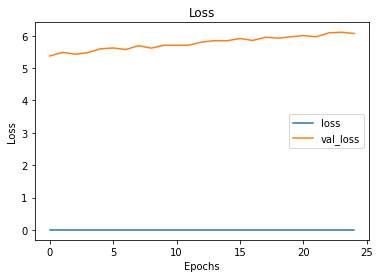

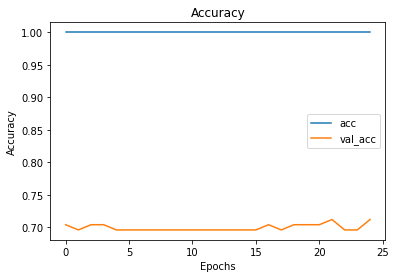

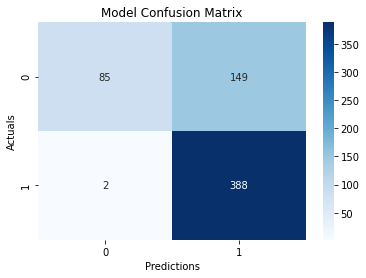



              precision    recall  f1-score   support

           0       0.98      0.36      0.53       234
           1       0.72      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.68      0.68       624
weighted avg       0.82      0.76      0.72       624



20/20 [==============================] - 3s 154ms/step - loss: 4.9216 - acc: 0.7580
Test Loss: 4.921589374542236
Test Acc: 0.7580128312110901


In [47]:
eval_results(base_history)

### Model 2: Looking at class imbalance, use early stopping, increase epochs

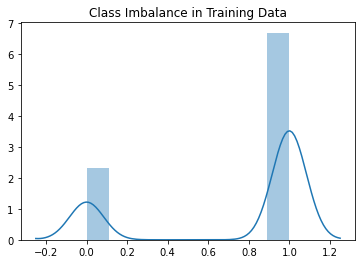

In [48]:
# Review training data class imbalance
#sns.countplot
sns.distplot(train_labels)
plt.title('Class Imbalance in Training Data')
plt.show()

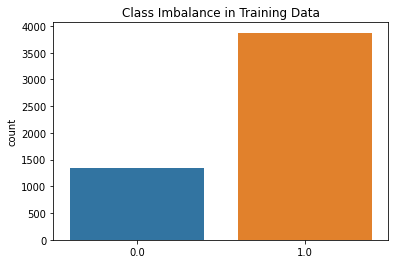

In [76]:
sns.countplot(train_labels)
plt.title('Class Imbalance in Training Data')
plt.show()

In [49]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)
weights_dict = dict(zip(np.unique(train_labels), weights))
weights_dict

{0.0: 1.9448173005219984, 1.0: 0.6730322580645162}

In [50]:
# Use early stopping and reduce learning rate 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
callbacks = [early_stopping, lr]

In [51]:
model_2 = models.Sequential()

model_2.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=input_shape))
model_2.add(MaxPooling2D((2, 2)))

model_2.add(Conv2D(32, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(2, 2))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))

model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [52]:
model_2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])

In [53]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

In [54]:
results2 = model_2.fit(train_images,
                   train_labels,
                   epochs=50,
                   batch_size=35,
                       validation_data=(X_val_split, y_val_split),
                   #validation_data=(val_images, val_labels),
                    #validation_split=0.2,
                   class_weight=weights_dict,
                   callbacks=callbacks)

Epoch 1/50
150/150 [==============================] - 93s 618ms/step - loss: 0.3474 - acc: 0.8478 - val_loss: 0.3767 - val_acc: 0.8400
Epoch 2/50
150/150 [==============================] - 75s 499ms/step - loss: 0.1206 - acc: 0.9546 - val_loss: 1.3797 - val_acc: 0.6640
Epoch 3/50
150/150 [==============================] - 78s 522ms/step - loss: 0.1133 - acc: 0.9582 - val_loss: 0.4594 - val_acc: 0.8400
Epoch 4/50
150/150 [==============================] - 72s 482ms/step - loss: 0.0843 - acc: 0.9680 - val_loss: 0.7449 - val_acc: 0.7520
Epoch 5/50
150/150 [==============================] - 73s 486ms/step - loss: 0.0811 - acc: 0.9678 - val_loss: 1.6090 - val_acc: 0.6720
Epoch 6/50
150/150 [==============================] - 71s 474ms/step - loss: 0.0813 - acc: 0.9703 - val_loss: 0.5554 - val_acc: 0.8000


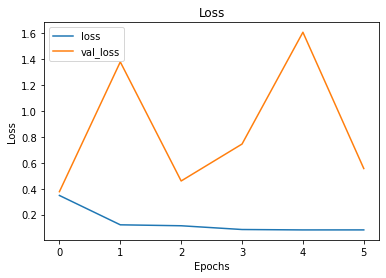

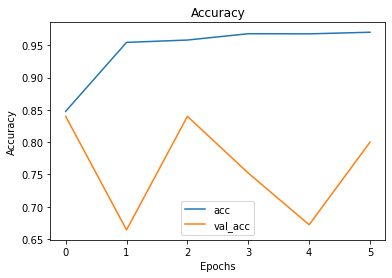

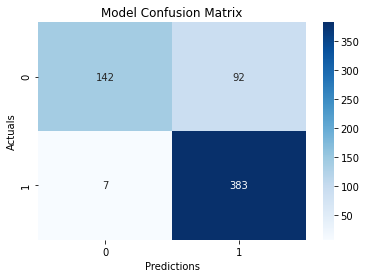



              precision    recall  f1-score   support

           0       0.95      0.61      0.74       234
           1       0.81      0.98      0.89       390

    accuracy                           0.84       624
   macro avg       0.88      0.79      0.81       624
weighted avg       0.86      0.84      0.83       624



20/20 [==============================] - 3s 131ms/step - loss: 0.5018 - acc: 0.8413
Test Loss: 0.5017794370651245
Test Acc: 0.8413461446762085


In [55]:
eval_results(results2)

### Model 3: more layers

In [56]:
model_3 = models.Sequential()

model_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))

model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(2, 2))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))

# cut out below
# model_3.add(Conv2D(64, (3, 3), activation='relu'))
# model_3.add(Conv2D(64, (3, 3), activation='relu'))
# model_3.add(MaxPooling2D((2, 2)))

#cut out below
# model_3.add(Conv2D(128, (3, 3), activation='relu'))
# model_3.add(Conv2D(128, (3, 3), activation='relu', data_format='channels_first'))
# model_3.add(MaxPooling2D((2, 2)))

model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

In [57]:
model_3.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [58]:
results_3 = model_3.fit(train_images,
                   train_labels,
                   epochs=50,
                   batch_size=32,
                   validation_data=(val_images, val_labels),     
                   #validation_split=0.2,
                    class_weight=weights_dict,
                   callbacks=[early_stopping])


Epoch 1/50
163/163 [==============================] - 202s 1s/step - loss: 0.6729 - acc: 0.7212 - val_loss: 0.5547 - val_acc: 0.7500
Epoch 2/50
163/163 [==============================] - 199s 1s/step - loss: 0.2509 - acc: 0.9022 - val_loss: 0.4378 - val_acc: 0.8750
Epoch 3/50
163/163 [==============================] - 203s 1s/step - loss: 0.1831 - acc: 0.9346 - val_loss: 0.3116 - val_acc: 0.8750
Epoch 4/50
163/163 [==============================] - 200s 1s/step - loss: 0.1589 - acc: 0.9465 - val_loss: 0.2378 - val_acc: 0.9375
Epoch 5/50
163/163 [==============================] - 198s 1s/step - loss: 0.1137 - acc: 0.9572 - val_loss: 0.0473 - val_acc: 1.0000
Epoch 6/50
163/163 [==============================] - 199s 1s/step - loss: 0.1084 - acc: 0.9653 - val_loss: 0.1905 - val_acc: 0.9375
Epoch 7/50
163/163 [==============================] - 213s 1s/step - loss: 0.1081 - acc: 0.9701 - val_loss: 0.1790 - val_acc: 0.9375
Epoch 8/50
163/163 [==============================] - 208s 1s/step - 

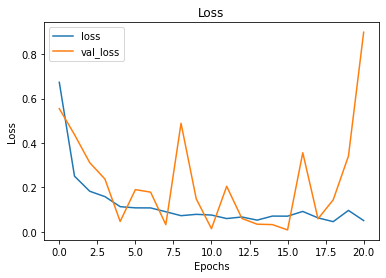

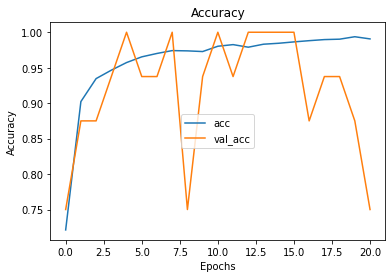

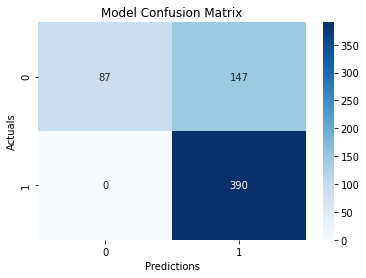



              precision    recall  f1-score   support

           0       1.00      0.37      0.54       234
           1       0.73      1.00      0.84       390

    accuracy                           0.76       624
   macro avg       0.86      0.69      0.69       624
weighted avg       0.83      0.76      0.73       624



20/20 [==============================] - 6s 285ms/step - loss: 1.4644 - acc: 0.7644
Test Loss: 1.4643977880477905
Test Acc: 0.7644230723381042


In [59]:
eval_results(results_3)

### Model 4: deeper model

In [60]:
model_4 = models.Sequential()

model_4.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=input_shape))
model_4.add(Conv2D(32, (3, 3), activation='relu'))
model_4.add(MaxPooling2D((2, 2)))

model_4.add(Conv2D(32, (3, 3), activation='relu'))
model_4.add(Conv2D(32, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(2, 2))

model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(MaxPooling2D((2, 2)))

model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(MaxPooling2D((2, 2)))

model_4.add(Flatten())
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))

In [61]:
model_4.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [62]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 27, 27, 64)       

In [63]:
results_4 = model_4.fit(train_images,
                        train_labels,
                   epochs=50,
                   batch_size=32,
                    validation_data=(X_val_split, y_val_split),
                    #validation_data=(val_images, val_labels),
                   #validation_split=.2,
                   class_weight=weights_dict,
                   callbacks=[early_stopping])

Epoch 1/50
163/163 [==============================] - 214s 1s/step - loss: 0.6027 - acc: 0.6952 - val_loss: 0.5036 - val_acc: 0.7520
Epoch 2/50
163/163 [==============================] - 204s 1s/step - loss: 0.2810 - acc: 0.8804 - val_loss: 0.4921 - val_acc: 0.8160
Epoch 3/50
163/163 [==============================] - 209s 1s/step - loss: 0.1877 - acc: 0.9247 - val_loss: 0.4254 - val_acc: 0.8160
Epoch 4/50
163/163 [==============================] - 206s 1s/step - loss: 0.1424 - acc: 0.9440 - val_loss: 0.6236 - val_acc: 0.8160
Epoch 5/50
163/163 [==============================] - 208s 1s/step - loss: 0.1342 - acc: 0.9492 - val_loss: 1.1973 - val_acc: 0.7520
Epoch 6/50
163/163 [==============================] - 215s 1s/step - loss: 0.1112 - acc: 0.9584 - val_loss: 0.3990 - val_acc: 0.8640
Epoch 7/50
163/163 [==============================] - 211s 1s/step - loss: 0.0936 - acc: 0.9622 - val_loss: 2.5804 - val_acc: 0.7520
Epoch 8/50
163/163 [==============================] - 211s 1s/step - 

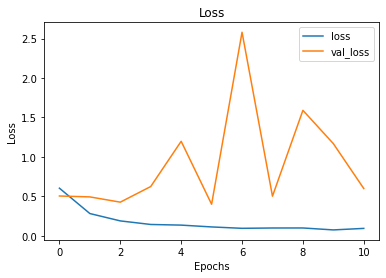

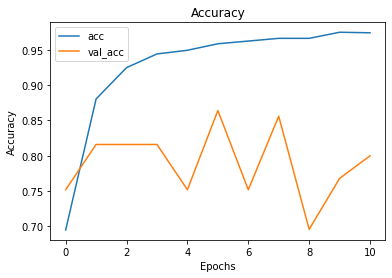

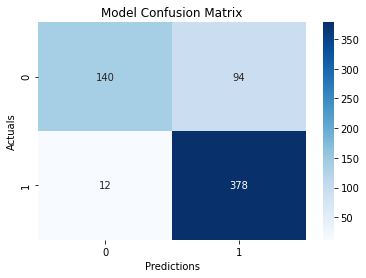



              precision    recall  f1-score   support

           0       0.92      0.60      0.73       234
           1       0.80      0.97      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.78      0.80       624
weighted avg       0.85      0.83      0.82       624



20/20 [==============================] - 6s 308ms/step - loss: 0.5841 - acc: 0.8301
Test Loss: 0.5840997099876404
Test Acc: 0.8301281929016113


In [64]:
eval_results(results_4)

### Model 5: Transfer Learning with VGG19 

In [65]:
from tensorflow.keras.applications import VGG16, VGG19

pretrained_cnn = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=input_shape)

#pretrained_cnn.trainable = False


In [66]:
# Freeze model
# you have to do this before you train model
pretrained_cnn.trainable = False

In [67]:
model_5 = models.Sequential()
model_5.add(pretrained_cnn)
model_5.add(Flatten())
model_5.add(Dense(128, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

In [68]:
pretrained_cnn.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [69]:
# Check whether the layer is trainable
#for layer in model_5.layers:
#     print(layer.name, layer.trainable)
    
# Check trainable weights
# print(len(model_5.trainable_weights))

In [70]:
# Check that it is frozen
# for layer in model_5.layers:
#     print(layer.name, layer.trainable)
    
# Check trainable weights
# print(len(model_5.trainable_weights))

In [71]:
model_5.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [72]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 21,073,217
Trainable params: 1,048,833
Non-trainable params: 20,024,384
_________________________________________________________________


In [73]:
results_5 = model_5.fit(train_images,
                   train_labels,
                   epochs=20,
                   batch_size=32,
                    validation_data=(X_val_split, y_val_split),
                    #validation_data=(val_images, val_labels),
                   #validation_split=.2,
                   class_weight=weights_dict,
                   callbacks=[early_stopping])

Epoch 1/20
163/163 [==============================] - 738s 5s/step - loss: 0.3373 - acc: 0.8762 - val_loss: 0.5928 - val_acc: 0.7840
Epoch 2/20
163/163 [==============================] - 744s 5s/step - loss: 0.1310 - acc: 0.9484 - val_loss: 1.1335 - val_acc: 0.6880
Epoch 3/20
163/163 [==============================] - 730s 4s/step - loss: 0.1128 - acc: 0.9572 - val_loss: 0.5747 - val_acc: 0.8320
Epoch 4/20
163/163 [==============================] - 729s 4s/step - loss: 0.0918 - acc: 0.9615 - val_loss: 0.8070 - val_acc: 0.8080
Epoch 5/20
163/163 [==============================] - 741s 5s/step - loss: 0.0901 - acc: 0.9636 - val_loss: 0.8531 - val_acc: 0.7840
Epoch 6/20
163/163 [==============================] - 726s 4s/step - loss: 0.0734 - acc: 0.9707 - val_loss: 0.9904 - val_acc: 0.7760
Epoch 7/20
163/163 [==============================] - 729s 4s/step - loss: 0.0742 - acc: 0.9718 - val_loss: 1.2388 - val_acc: 0.7440
Epoch 8/20
163/163 [==============================] - 734s 5s/step - 

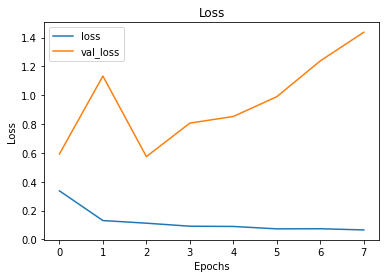

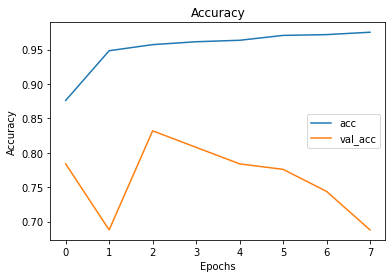

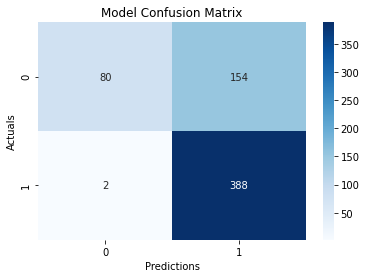



              precision    recall  f1-score   support

           0       0.98      0.34      0.51       234
           1       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.85      0.67      0.67       624
weighted avg       0.81      0.75      0.71       624



20/20 [==============================] - 79s 4s/step - loss: 1.3027 - acc: 0.7500
Test Loss: 1.302717685699463
Test Acc: 0.75


In [74]:
eval_results(results_5)

## Conclusions and Recommendations
***
The best model had an accuracy rate of almost 84%, which is not great, but still pretty good. Most of the models I built had an accuracy of 70% and up. The models most likely need some more hyperparameter tuning and general tuning. My best model is struggles with predicting pneumonia images and is more likely to predict false negatives.

My recommendations would be to use this model as a first opinion. Then professional doctors would be used as a necessary second opinion to finally determine whether or not a patient has pneumonia. I would also recommend training these models on adult X-Ray images, since these images are only of pedatric patients ranging from ages one to five. I would also recommend to crop out (if possible) any visible organs that can confuse the models when classifying images. 

## Future Work
***
The X-Ray images still have some organs visible in the image which can confuse the model. If these organs can be cropped out before being included in the image sets, I think that would help the model perform better.

For this image classification, I used 224 X 224 px image sizes initially. This made model training EXTREMELY slow. I lowered the image sizes to 128 X 128 px which improved runtime. With more time, I would have liked to use 64 X 64 px or 32 X 32 px. This would greatly improve runtime and would allow me more time to run other models.

I would also like to research other methods of image classification and do some CNN tuning. I believe that some more preprocessing would help improve the models performance too.

I also believe it would beneficial to train the model on adult X-Ray images. These X-ray images were obtained from pediatric patients so training it on adult images would be beneficial to improving the model.